# Examples with synthetic data
0) A single interacting pattern (word).

1) Few overlapping words.

2) Several random interactions (optional).

In this notebook, given a set of variables we will generate synthetic data from a distribution that presents different sets of interacting patterns, under different conditions (changing samples, intensity and sign of interactions, etc.).

Make sure uBIAmodule.py is located in your working folder before importing.

In [1]:
from itertools import product, combinations
import numpy as np
import math
import operator
from matplotlib import pyplot as plt
import functools
def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)
def list_powerset(lst):
    return functools.reduce(lambda result, x: result + [subset + [x] for subset in result], lst, [[]])
from collections import Counter
import time
from sklearn.utils import shuffle
from heapq import nsmallest
import uBIAmodule

## Defining parameters of underlying probability distribution
Data is generated from log-linear model (Amari, 2001):
$$\log p(x|\theta) = \sum_i^N \theta_i x_i + \sum_{ij}^N \theta_{ij} x_i x_j + \sum_{ijk}^N \theta_{ijk} x_i x_j x_k +...= \sum_{\nu} \theta_{\nu} \prod_{i\in V_{\nu}} x_i -\log \mathcal{Z}\\$$
$$\theta_i \sim \mathcal{N}(\mu_1, \sigma_1^2),\, \theta_{i_1... i_r} \sim \mathcal{N}(\mu_J, \sigma_J^2)$$

## Setting parameters for probability distribution, and for uBIA

In [13]:
# PARAMETERS TO TEST

#number of samples for inference
M=800#400#1600  #---------------change number of samples
#intensity of interaction
muJ=1.0#0.5#1.5  #---------------change intensity of interaction 

Jp0=[(2,3,6)]   #--------------change word/s
Jint0=[muJ]#[-muJ]#--------------change sign +-
#Jp0=[(2,3,6),(1,2),(6,15,16,17)]
#Jint0=[muJ,-muJ,muJ]

#type of distribution
distJ_type=0
    #type0: a predefined set of interactions Jp0 with intensity Jint0
    #type1: two gauss for Js at +/- muJ
    #type2: one gauss at 0

# EXTRA PARAMETERS
mu1=-0.7 #for matching firing rate
p1i=np.exp(mu1)/(1.+np.exp(mu1))
sig1=0.1
sigJ=0.2#0.1

#dimension of data
T=18

#density of interactions per dimension (each variable participates in ~ alfa int)
alfa=2. 
#number of interactions of 2nd, 3rd and 4th order (total 3*Nj)
Nj=int(round(alfa*T/9.))
#number of steps to do path integral for magnetization
n_e=20 
#number of shufflings for significance test
nmix=10
#number of pattern in full Ising model, after filtering by field
Nmax=1000
#total samples for analysis vs M
Mtotal=3200

np.random.seed(0)

print("Parameters ready")

Parameters ready


## Generating the probability distribution with $2^T$ states
(~1 min)

In [14]:
print("Available number of states: ",len(list(product(range(2), repeat=T))))

dep2=list(combinations(range(T),2))
dep3=list(combinations(range(T),3))
dep4=list(combinations(range(T),4))
J2=[dep2[i] for i in np.random.choice(range(int(nCr(T,2))), Nj, replace=False)]
J3=[dep3[i] for i in np.random.choice(range(int(nCr(T,3))), Nj, replace=False)]
J4=[dep4[i] for i in np.random.choice(range(int(nCr(T,4))), Nj, replace=False)]
Jp=J2+J3+J4

# Individual biases
J1=np.random.normal(mu1, sig1, T)

# Interactions values
if distJ_type==2:
    Jall=[np.random.normal(0., sigJ) for i in range(3*Nj)]
elif distJ_type==1:
    Jall=[np.random.normal(np.random.choice([-1,1])*muJ, sigJ) for i in range(3*Nj)]
else: #distJ_type==0:#predefined interactions
    Jp=Jp0
    Jall=Jint0

iteTlist=list(product(range(2), repeat=T))
iteT=product(range(2), repeat=T)

# Energies, probabilities for different patterns (~1min)
Epatt=[np.dot(i,J1)+np.sum([Jall[j]*np.prod(np.array(i)[np.array(Jp[j])]) for j in range(len(Jall))]) for i in iteT]
prob=[np.exp(Epatt[i]) for i in range(2**T)]
Zpar=np.sum(prob)
prob=[pp/Zpar for pp in prob]
print("Checking normalization: ",np.sum(prob))
print("Entropy of the distribution: ",-1*np.dot(prob,np.log(prob)))

print("\nList of interacting patterns:")
for i in range(len(Jall)):
    print(Jp[i],Jall[i])

Available number of states:  262144
Checking normalization:  1.0
Entropy of the distribution:  11.535228309602626

List of interacting patterns:
(2, 3, 6) 1.0


## Generating samples from probability distribution

In [15]:
# generating samples from that probability distribution
draw = np.random.choice(range(2**T),Mtotal, p=prob)
patt=list(product(range(2), repeat=T))
samples_total=[patt[i] for i in draw]
samples=samples_total[:M]

print("First five samples:")
for sami in samples[:5]:
    print(sami)

First five samples:
(0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1)
(1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1)
(1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1)
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0)
(0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0)


## Inferring codewords with uBIA
As a first step we list all the patterns that occur in the samples (if $T$ is large, we need to be careful with this step).

Secondly, we include in this list patterns which do not occur but could be a relevant pattern.

Next, we calculate "the fields" of each pattern, checking how such patterns over or under occur in relation to our expectation (no interaction). The field gives the individual evidence that a pattern should be considered as a codeword. Here we select the Nmax patterns with higher fields.

Because overlapping patterns or codewords try to explain the same correlations, we need a type of competition between them to determine which are the true patterns and which are by-products of the others. This competition is implemented through couplings $J_{\mu\nu}$.

A key parameter of uBIA is epsilon, the inverse regularization. Epsilon regulates how far we move away from our "no-interaction null model". Epsilon can not be too large as some of the approximation of the method are not longer valid, but if it is too small we do not allow the correlations in the samples to matter.

Finally, we present a list of words ordered by their marginal magnetizations, a quantity directly proportional to their probability of being a codeword. These results are presented as:

(word, marginal magnetization, individual field, frequency in samples, expected frecuency from null model)

The list ordered by marginal magnetization is presented at the largest epsilon allowed by our approximations, but you can checked how the list changes at other levels ($ne_{test} \in\{1,2,..,20\}$).

In [16]:
hcutoff=0.05 #to include in the list of candidate words patterns that do not occur be could be relevant.
epsilon_tylor_limit=0.5 #this should be <1. It regulates the relation between effective field (coming from couplings) vs individual fields

M=len(samples) #number of samples
pi=np.sum(samples,axis=0)
pi=[1.*i/M for i in pi] #empirical individual probabilities

start_time = time.time()

# making a list of possible candidate codewords
dicset=uBIAmodule.extract_patt(samples)
print("Number of candidate words: ",len(dicset))

# Calculating "the fields" of each pattern, and selecting the Nmax patterns with higher fields.
sorted_patt=uBIAmodule.magn_field(dicset,M,pi)
h0=[sorted_patt[i][1][0] for i in range(Nmax)]
#print(len(sorted_patt))

# Calculating couplings for competition between candidate words
Jvw=uBIAmodule.couplings(sorted_patt, M, pi, Nmax)

results=uBIAmodule.marg_magn_h1ef(h0, Jvw, M)
mi=results[0]
h1ef=results[1]

neopt=uBIAmodule.level_inverse_reg(h0,h1ef,n_e,epsilon_tylor_limit)
print("Largest epsilon allowed by our approximations:",neopt,"*1/(20M)")

mm_sorted_patt=uBIAmodule.marg_magn_sorted(sorted_patt,mi,neopt)

print("\n Interactions from probability:")
for i in range(len(Jall)):
    print(Jp[i],Jall[i])

print("\n Sorted by marginal magnetization at e*:")
for pp in mm_sorted_patt[:12]:
    print(pp)

print("\n Sorted by field (individual evidence of words):")
for pp in sorted_patt[:12]:
    print(pp)

netest=5
mm_sorted_patt20=uBIAmodule.marg_magn_sorted(sorted_patt,mi,netest)#n_e<20
print("\n Sorted by marginal magnetization at epsilon=",netest,"*1/(20M):")
for pp in mm_sorted_patt20[:12]:
    print(pp)

print("\n--- %s seconds ---" % (time.time() - start_time))#with T=18 ->16s

Number of candidate words:  113220
Largest epsilon allowed by our approximations: 10 *1/(20M)

 Interactions from probability:
(2, 3, 6) 1.0

 Sorted by marginal magnetization at e*:
((2, 3, 6), [0.08559511801415481, 261.0716787812499, 89, 55.89000000000001])
((2, 3, 4, 6), [0.04559876042271131, 118.69968824342189, 41, 18.793012500000003])
((13, 17), [0.04143808606768619, 89.67496778125005, 107, 86.13])
((2, 4, 6), [0.03620375257138691, 128.28274906445307, 70, 46.4025])
((2, 3, 5, 6), [0.03360021547365126, 87.6392069934219, 38, 18.793012500000003])
((3, 12, 15), [0.032504261569042014, 41.847173802405294, 24, 38.27705625])
((15, 17), [0.03081855248452573, 39.73529451220698, 73, 88.41375])
((4, 8), [0.02719403546628759, 25.867901892578118, 72, 85.4075])
((1, 2, 3, 6), [0.024922504514575686, 68.20169310761524, 36, 18.932737500000005])
((2, 3, 6, 16), [0.02419127830408279, 71.29633483413456, 36, 18.583425000000002])
((4, 12, 13), [0.022085294376844068, 49.12127386101998, 46, 30.9585375])
(

## Some internal checks
Distribution of couplings

Negative couplings

815.5666638200722
-5034.464042059335
806814


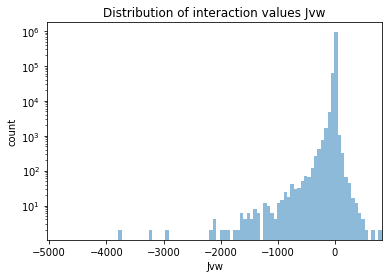

In [17]:
dataJ=Jvw.flatten()
print(max(dataJ))
print(min(dataJ))
print(np.count_nonzero(dataJ))


bins = np.linspace(math.ceil(min(dataJ)), 
                   math.floor(max(dataJ)),
                   100)
plt.yscale('log')#, nonpositive='clip')
plt.xlim([min(dataJ)-5, max(dataJ)+5])
plt.hist(dataJ, bins=bins, alpha=0.5)
plt.title('Distribution of interaction values Jvw')
plt.xlabel('Jvw')
plt.ylabel('count')

plt.show()

In [18]:
Jneg=nsmallest(6, dataJ)
print(Jneg)

indexJneg=np.argwhere(Jvw<=Jneg[-1])
print(indexJneg)
# for pp in sorted_patt[:8]:
#     print(pp)
for iJ in indexJneg:
    print(sorted_patt[iJ[0]],sorted_patt[iJ[1]])

print(Jvw[indexJneg[0][0]][indexJneg[0][1]])
print(Jvw[indexJneg[1][0]][indexJneg[1][1]])

[-5034.464042059335, -5034.464042059335, -3737.7951661254237, -3737.7951661254237, -3235.74682324297, -3235.74682324297]
[[ 0  1]
 [ 0  7]
 [ 0 20]
 [ 1  0]
 [ 7  0]
 [20  0]]
((2, 3, 6), [261.0716787812499, 89, 55.89000000000001]) ((2, 6), [153.70125, 165, 138.0])
((2, 3, 6), [261.0716787812499, 89, 55.89000000000001]) ((2, 3), [73.93861738281227, 160, 139.72500000000002])
((2, 3, 6), [261.0716787812499, 89, 55.89000000000001]) ((3, 6), [48.538799999999796, 147, 129.60000000000002])
((2, 6), [153.70125, 165, 138.0]) ((2, 3, 6), [261.0716787812499, 89, 55.89000000000001])
((2, 3), [73.93861738281227, 160, 139.72500000000002]) ((2, 3, 6), [261.0716787812499, 89, 55.89000000000001])
((3, 6), [48.538799999999796, 147, 129.60000000000002]) ((2, 3, 6), [261.0716787812499, 89, 55.89000000000001])
-5034.464042059335
-3737.7951661254237


## Plotting marginal magnetization (proportional to probability of being a codeword) for patterns as a function  of inverse regularization
True patterns in red

In [19]:
def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

indtrue=[]

for jp in Jp:
    ind=find_indices(sorted_patt, lambda e: e[0]== jp)
    print(ind)
    if ind!=[]:
        indtrue.append(ind[0])
#        plt.plot(mi[ind[0]])#,'bs')

#plt.show()
print(indtrue)

[0]
[0]


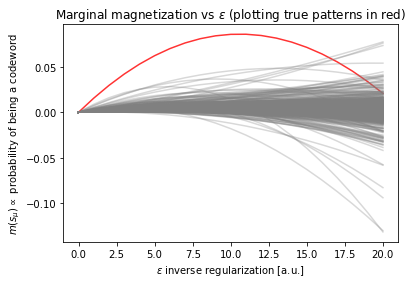

In [20]:
for j in range(len(mi)):
    if j in indtrue:
        plt.plot(mi[j],'red',alpha=0.8)
    else:
        plt.plot(mi[j],'gray',alpha=0.3)
        
plt.title('Marginal magnetization vs $\epsilon$ (plotting true patterns in red)')
plt.ylabel('$m(s_{\mu}) \propto$ probability of being a codeword')
plt.xlabel('$\epsilon$ inverse regularization [a.u.]')

plt.show()

## Significance level

Through reshuffling of the columns of our original matrix (that is, keeping marginal probabilities but deleting interactions), we can obtain how large the marginal magnetization gets when there are no interactions. Namely, the positive values of marginal magnetizations are due to finite sampling.


(Slowest part, 2-3 mins for T~18)

mc[x_,m1_]:=m1 x^(-0.23)Exp[-0.015 (Log[x]^2)]

mc[n_false, m1= magnetization 1st]= m1 f(nf) (see sacaling between magn and n_false in mlevel_nf.nb)

mc[0.3,1]=1.29 for $M \in (200,800)$

mc[0.1,1]=1.57 for $M \in (800,1600)$

mc[0.03,1]=1.86 for $M \in (1600,3200)$

In [21]:
start_time = time.time()

mcx=np.zeros((10,n_e+1)) #ten largest values of marg. magnetizations for codewords in shuffled data (for each level of ee)
mclowx=np.zeros((10,n_e+1))

for nn in range(nmix):#nmix

    #shuffling columns of data (keeping the firing rate fixed)
    tsam=np.transpose(samples)
    tsam_shuf=[shuffle(ti) for ti in tsam]
    sam_shuf=np.transpose(tsam_shuf)

    dicset_s=uBIAmodule.extract_patt(sam_shuf)
    #print(len(dicset_s))

    sorted_patt_s=uBIAmodule.magn_field(dicset_s,M,pi)
    Nmax_s=min(Nmax,len(sorted_patt_s))
    h0_s=[sorted_patt_s[i][1][0] for i in range(Nmax)]
    #print(len(sorted_patt_s))

    Jvw_s=uBIAmodule.couplings(sorted_patt_s, M, pi,Nmax_s)

    results_s=uBIAmodule.marg_magn_h1ef(h0_s, Jvw_s, M)
    mi_s=results_s[0]
    h1ef_s=results_s[1]
    
    for kk in range(n_e+1):
        #how strong can the marginal magnetizetion be for every level of \epsilon?
        mcx[:,kk]+=sorted(mi_s[:,kk],reverse=True)[:10]
        mclowx[:,kk]+=sorted(mi_s[:,kk])[:10]
    
    print(nn,"--- %.2f seconds ---" % (time.time() - start_time))

mcx=(1./nmix)*mcx
mclowx=(1./nmix)*mclowx

print(mcx[0])
#print(mclowx[0])

0 --- 20.75 seconds ---
1 --- 37.39 seconds ---
2 --- 56.09 seconds ---
3 --- 75.09 seconds ---
4 --- 93.18 seconds ---
5 --- 109.27 seconds ---
6 --- 126.43 seconds ---
7 --- 144.09 seconds ---
8 --- 160.28 seconds ---
9 --- 177.68 seconds ---
[0.         0.00466972 0.00919116 0.01356391 0.01778765 0.0218621
 0.02578707 0.02956239 0.03318799 0.03666382 0.04017048 0.04357093
 0.0469418  0.05024777 0.05358676 0.05686216 0.06007249 0.06335019
 0.06669096 0.07005711 0.07357098]


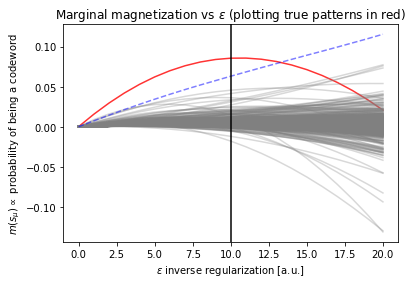

In [24]:
if M<800:
    mc1=1.29 #for $M \in (200,800)$
elif (M>=800) and (M<1600):
    mc1=1.57 #for $M \in (800,1600)$
elif M>=1600:
    mc1=1.86 #for $M \in (1600,3200)$

for j in range(len(mi)):
    if j in indtrue:
        plt.plot(mi[j],'red',alpha=0.8)
    else:
        plt.plot(mi[j],'gray',alpha=0.3)
        
plt.plot(mc1*mcx[0],'b--',alpha=0.5)

plt.axvline(x=neopt, color='k')       

plt.title('Marginal magnetization vs $\epsilon$ (plotting true patterns in red)')
plt.ylabel('$m(s_{\mu}) \propto$ probability of being a codeword')
plt.xlabel('$\epsilon$ inverse regularization [a.u.]')

plt.show()

## Finally let's have our list of patterns above our threshold

In [25]:
codewords=[patt for patt in mm_sorted_patt if patt[1][0]>mc1*mcx[0][neopt]]

lencode=len(codewords)
print(lencode)

print("\nCodewords (above threshold in \epsilon*): ")
for pp in codewords[:min(lencode,5)]:
    print(pp)
    
print("\nWords ordered by probability of being a codeword: ")
for pp in mm_sorted_patt[:5]:
    print(pp)

1

Codewords (above threshold in \epsilon*): 
((2, 3, 6), [0.08559511801415481, 261.0716787812499, 89, 55.89000000000001])

Words ordered by probability of being a codeword: 
((2, 3, 6), [0.08559511801415481, 261.0716787812499, 89, 55.89000000000001])
((2, 3, 4, 6), [0.04559876042271131, 118.69968824342189, 41, 18.793012500000003])
((13, 17), [0.04143808606768619, 89.67496778125005, 107, 86.13])
((2, 4, 6), [0.03620375257138691, 128.28274906445307, 70, 46.4025])
((2, 3, 5, 6), [0.03360021547365126, 87.6392069934219, 38, 18.793012500000003])
